# 02 - Training

## A - Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from metaboDGD.src.dataset import MetaboliteDataset
from metaboDGD.util import train
from metaboDGD.src import model
import matplotlib.pyplot as plt
import torch
import torch.distributions as D

## B - Retrieve Dataframe and Cohorts

In [2]:
dir = 'outputs/'
df_fname = 'CombinedDataset_CAMP.csv'
df_exp_fname = 'Exponent_CombinedDataset_CAMP.csv'
cohorts_fname = 'cohorts.pkl'

In [3]:
df = pd.read_csv(dir + df_fname)
df.set_index('Unnamed: 0', inplace=True)
df.index.name = None

df_exp = pd.read_csv(dir + df_exp_fname)
df_exp.set_index('Unnamed: 0', inplace=True)
df_exp.index.name = None

f = open(dir + cohorts_fname, 'rb')
cohorts = pickle.load(f)

## C - TrainLoader and Dataset

In [4]:
train_dict = {}
test_dict  = {}

train_lbls = []
test_lbls  = []

plot_counts = {}

In [5]:
for c in cohorts.keys():
    # Get Sample IDs for training and testing
    _train, _test = train_test_split(cohorts[c]['sample_list'],
                     train_size=0.8,
                     random_state=100)
    # plot_counts[c] = len(_train)
    train_dict[c] = df_exp.loc[_train].to_numpy()
    test_dict[c]  = df_exp.loc[_test].to_numpy()

    train_lbls += [c for i in range(len(_train))]
    test_lbls  += [c for i in range(len(_test))]

train_df = np.vstack(list(train_dict.values()))
test_df  = np.vstack(list(test_dict.values()))

train_lbls = np.asarray(train_lbls, dtype=np.object_)
test_lbls = np.asarray(test_lbls, dtype=np.object_)

train_dataset = MetaboliteDataset(train_df, train_lbls)
test_dataset  = MetaboliteDataset(test_df , test_lbls)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset , batch_size=64, shuffle=False)

dgd_model = model.MetaboDGD(
    latent_dim=10,
    output_dim=1915,
    dec_hidden_layers_dim=[500, 1000, 1500],
    dec_output_prediction_type='mean',
    dec_output_activation_type='softplus',
    n_comp=8,
    cm_type='diagonal'
)

dgd_model, train_rep, test_rep, history = train.train_dgd(
    dgd_model=dgd_model,
    train_loader=train_loader,
    validation_loader=test_loader,
    n_epochs=100,
    lr_schedule_epochs=None,
    lr_schedule=[1e-4, 1e-3, 1e-2],
    optim_betas=[0.5, 0.7],
    wd=1e-4,
)

In [6]:
history

,train_loss,val_loss,train_recon_loss,val_recon_loss,train_dist_loss,val_dist_loss,epoch
0,22.470113,22.809682,21.988563,22.332183,92.216741,91.440992,1
1,22.436969,22.769635,21.961234,22.297903,91.103223,90.336783,2
2,22.394614,22.715243,21.924629,22.249217,90.002232,89.243941,3
3,22.337111,22.641297,21.872814,22.180916,88.912904,88.162899,4
4,22.259234,22.543543,21.800564,22.088746,87.835431,87.093559,5
...,...,...,...,...,...,...,...
95,4.369500,4.386063,4.254061,4.272070,22.106615,21.829594,96
96,4.330517,4.348763,4.217153,4.236821,21.709271,21.437060,97
97,4.292345,4.311790,4.181019,4.201859,21.318951,21.051762,98
98,4.254280,4.275517,4.144955,4.167562,20.935773,20.673424,99


Text(0.5, 1.0, 'Training Loss Curve - Total Loss')

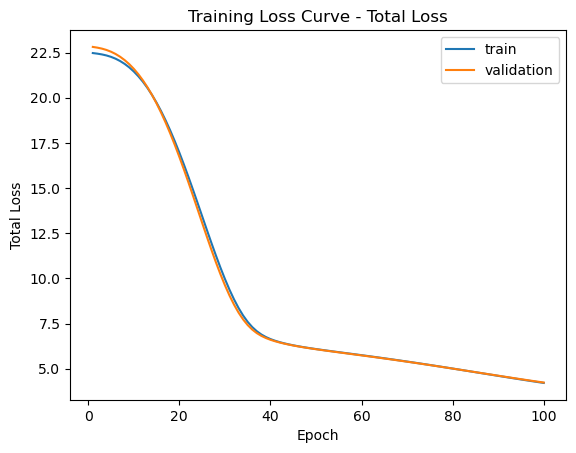

In [7]:
plt.plot(history['epoch'], history['train_loss'], label='train')
plt.plot(history['epoch'], history['val_loss']  , label='validation')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Loss Curve - Total Loss")

Text(0.5, 1.0, 'Training Loss Curve - Reconstruction Loss')

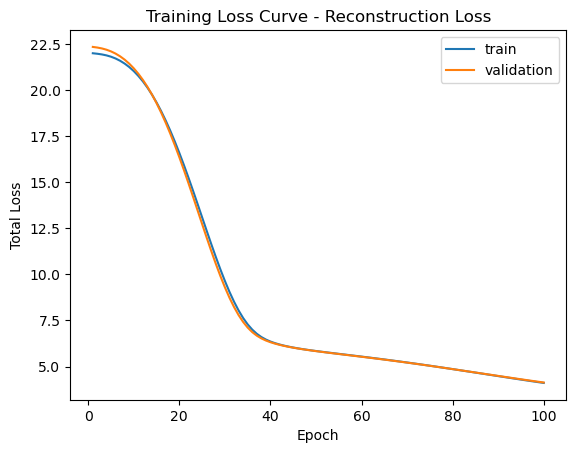

In [8]:
plt.plot(history['epoch'], history['train_recon_loss'], label='train')
plt.plot(history['epoch'], history['val_recon_loss']  , label='validation')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Loss Curve - Reconstruction Loss")

Text(0.5, 1.0, 'Training Loss Curve - GMM Distribution Loss')

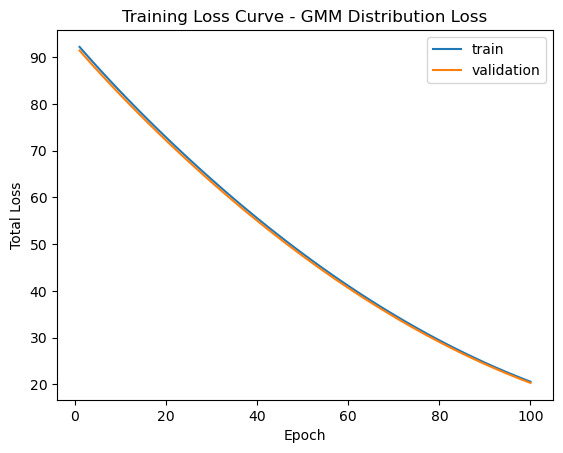

In [9]:
plt.plot(history['epoch'], history['train_dist_loss'], label='train')
plt.plot(history['epoch'], history['val_dist_loss']  , label='validation')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Training Loss Curve - GMM Distribution Loss")